<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_GRU_Avec_Attention_Hierarchique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones récurrent de type GRU associé à une **couche d'attention hiérarchique** comprenant un **vecteur contexte** pour réaliser des prédictions sur notre série temporelle.  

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle et du dataset pour l'entrainement

In [2]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, nbr_sequences, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(nbr_sequences,drop_remainder=True).prefetch(1)
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

def prepare_dataset_XY_AvecGlissement(serie, taille_fenetre, nbr_sequences, batch_size, buffer_melange,glissement):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=glissement, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(nbr_sequences,drop_remainder=True).prefetch(1)
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

def prepare_dataset_XY_Paquets(serie, taille_fenetre, nbr_sequences, batch_size, buffer_melange, glissement):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=glissement, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(nbr_sequences,drop_remainder=True).prefetch(1)
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset



# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit)

temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de validation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

In [10]:
# Cration du dataset
Nbr_Sequences = 4
taille_fenetre = 5
glissement = 5
batch_size = 1
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(serie,taille_fenetre,Nbr_Sequences, batch_size, buffer_melange)
dataset = prepare_dataset_XY_AvecGlissement(serie,taille_fenetre,Nbr_Sequences, batch_size, buffer_melange,glissement)
dataset = prepare_dataset_XY_Paquets(serie,taille_fenetre,Nbr_Sequences, batch_size, buffer_melange,glissement)

# Création du dataset X,Y de validation
dataset_Val = prepare_dataset_XY(x_validation,taille_fenetre,Nbr_Sequences, batch_size, buffer_melange)
dataset_Val = prepare_dataset_XY_AvecGlissement(x_validation,taille_fenetre,Nbr_Sequences, batch_size, buffer_melange, glissement)
dataset_Val = prepare_dataset_XY_Paquets(x_validation,taille_fenetre,Nbr_Sequences, batch_size, buffer_melange, glissement)


In [70]:
dataset2 = dataset
dataset2 = dataset2.map(lambda x,y: [x,y[0,0,0]])

In [69]:
print(len(list(dataset2.as_numpy_iterator())))
for element in dataset2.take(1):
  print(element)

InvalidArgumentError: ignored

In [25]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element)

72
(<tf.Tensor: shape=(1, 4, 5), dtype=float64, numpy=
array([[[50.3255885 , 51.20449668, 50.14235382, 42.64136576,
         51.11326649],
        [52.88565963, 49.03812353, 48.70217339, 47.1570353 ,
         49.79873529],
        [56.43695387, 56.57781242, 45.57803708, 51.30290334,
         48.65235935],
        [48.06710511, 51.66228593, 44.97391579, 50.35966034,
         52.55821168]]])>, <tf.Tensor: shape=(1, 4, 1), dtype=float64, numpy=
array([[[52.88565963],
        [56.43695387],
        [48.06710511],
        [46.15010903]]])>)


In [17]:
debut = 0
for i in range(0,Nbr_Sequences+2):
  print(serie[debut:debut+taille_fenetre])
  debut = debut+taille_fenetre

[50.3255885  51.20449668 50.14235382 42.64136576 51.11326649]
[52.88565963 49.03812353 48.70217339 47.1570353  49.79873529]
[56.43695387 56.57781242 45.57803708 51.30290334 48.65235935]
[48.06710511 51.66228593 44.97391579 50.35966034 52.55821168]
[46.15010903 49.08647748 44.94473309 51.61170504 46.05306289]
[55.19675543 49.86130874 50.30665115 47.43291954 53.94629933]


# Création du modèle GRU avec couche d'attention possédant un vecteur de contexte

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Sous forme de shéma, notre réseau est donc le suivant :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/Attention_VecteurContexte1.png?raw=true" width="1200"> 

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

On créé une classe dérivée de la classe [Layer](https://keras.io/api/layers/base_layer/#layer-class) de Keras. Les méthodes utilisées sont les suivantes :  
 - [build](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#build) : Permet de créer les variables utilisées par la couche (commes les poids et les offsets)
 - [call](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#call) : Permet d'implanter la logique de la couche

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/Attention_VecteurContexte2.png?raw=true" width="1200"> 

Parmi les nouvelles fonctions de Tensorflow et de Keras utilisées, on trouve :
- [transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) : Permet de transposer un tenseur et éventuellement de reconstituer l'ordre des axes avec l'argument `perm`
- [add_weight](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#add_weight) : Méthode de la classe Layers de Keras, qui permet d'ajouter un paramètre (poids et offset ou autre) qui sera une variable mémoire pour la couche construite. 


In [ ]:
# Classe d'attention simple
# Applique les poids d'attention sur les vecteurs de la couche récurrente

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Attention(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self,dim_att):
    self.dim_att = dim_att          # Dimension du vecteur d'attention
    super().__init__()              # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.W = self.add_weight(shape=(self.dim_att,input_shape[2]),initializer="normal",name="W")
    self.b = self.add_weight(shape=(self.dim_att,1),initializer="zeros",name="b")
    self.u = self.add_weight(shape=(self.dim_att,1),initializer="normal",name="u")
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :   x : Tenseur d'entrée de dimension (None, nbr_v,dim)
  def call(self,x):
    # Calcul de la matrice XH contenant les
    # représentations cachées des vecteurs
    # issus de la couche GRU
    x = tf.transpose(x,perm=[0,2,1])          # x = (None, dim,20)
    Xh = K.dot(self.W,x)                      # Xh = (dim_att,None,20)
    Xh = tf.transpose(Xh,perm=[1,0,2])        # Xh = (None, dim_att,20)
    Xh = Xh + tf.expand_dims(self.b,axis=0)   # Xh = (None, dim_att,20) + (None, dim_att,1)
    Xh = K.tanh(Xh)                           # Xh = (None, dim_att,20)

    # Calcul des poids d'attention normalisés
    Xh = tf.transpose(Xh,perm=[0,2,1])        # Xh = (None,20,dim_att)
    a = K.dot(Xh,self.u)                      # a = (None,20,1)
    a = tf.keras.activations.softmax(a,axis=1)

    # Calcul du vecteur d'attention
    xa = tf.multiply(Xh,a)                    # xa = (None,20,dim)
    sortie = K.sum(xa,axis=1)                 # sortie = (None,40)
    return sortie

  def compute_output_shape(self,input_shape):
    return(input_shape[0],input_shape[2])


In [ ]:
dim_GRU = 40

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)

model = tf.keras.Sequential()

model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Lambda(Traitement_Entrees), input_shape = (Nbr_Sequences, taille_fenetre)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.GRU(dim_GRU,return_sequences=True)))
model.add(tf.keras.layers.TimeDistributed(Couche_Attention(dim_GRU)))
model.add(tf.keras.layers.GRU(dim_GRU,return_sequences=True))
model.add(Couche_Attention(dim_GRU))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Lambda(Traitement_Sorties))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, 32, 20, 1)         0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 32, 20, 40)        5160      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 32, 40)            1680      
_________________________________________________________________
gru_7 (GRU)                  (None, 32, 40)            9840      
_________________________________________________________________
couche__attention_7 (Couche_ (None, 40)                1680      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
_________________________________________________________________
lambda_7 (Lambda)            (None, 1)                

**2. Optimisation du taux d'apprentissage**

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100
45/45 [==============================] - 5s 20ms/step - loss: 65.3854 - mae: 65.8852

Epoch 00001: loss improved from inf to 98.65334, saving model to poids.hdf5
Epoch 2/100
45/45 [==============================] - 1s 20ms/step - loss: 65.3816 - mae: 65.8814

Epoch 00002: loss improved from 98.65334 to 98.64921, saving model to poids.hdf5
Epoch 3/100
45/45 [==============================] - 1s 20ms/step - loss: 65.3768 - mae: 65.8767

Epoch 00003: loss improved from 98.64921 to 98.64407, saving model to poids.hdf5
Epoch 4/100
45/45 [==============================] - 1s 16ms/step - loss: 65.3709 - mae: 65.8708

Epoch 00004: loss improved from 98.64407 to 98.63773, saving model to poids.hdf5
Epoch 5/100
45/45 [==============================] - 1s 19ms/step - loss: 65.3634 - mae: 65.8633

Epoch 00005: loss improved from 98.63773 to 98.62962, saving model to poids.hdf5
Epoch 6/100
45/45 [==============================] - 1s 20ms/step - loss: 65.3540 - mae: 65.8538

Epoch 00006:

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

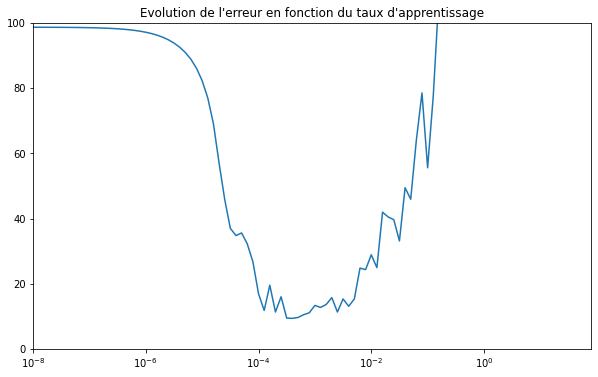

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 100])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [ ]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [ ]:
# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(lr=1e-3)


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset,validation_data=dataset_Val, epochs=500,verbose=1, callbacks=[CheckPoint])

Epoch 1/500
45/45 [==============================] - 5s 43ms/step - loss: 9.5369 - mae: 10.0233 - val_loss: 14.9486 - val_mae: 15.4411

Epoch 00001: loss improved from inf to 9.48536, saving model to poids.hdf5
Epoch 2/500
45/45 [==============================] - 1s 23ms/step - loss: 19.5945 - mae: 20.0889 - val_loss: 14.7780 - val_mae: 15.2701

Epoch 00002: loss did not improve from 9.48536
Epoch 3/500
45/45 [==============================] - 1s 23ms/step - loss: 13.6473 - mae: 14.1390 - val_loss: 15.5190 - val_mae: 16.0103

Epoch 00003: loss did not improve from 9.48536
Epoch 4/500
45/45 [==============================] - 1s 23ms/step - loss: 19.0926 - mae: 19.5845 - val_loss: 13.4861 - val_mae: 13.9788

Epoch 00004: loss did not improve from 9.48536
Epoch 5/500
45/45 [==============================] - 1s 23ms/step - loss: 10.9519 - mae: 11.4405 - val_loss: 14.2609 - val_mae: 14.7525

Epoch 00005: loss did not improve from 9.48536
Epoch 6/500
45/45 [==============================] - 

KeyboardInterrupt: ignored

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

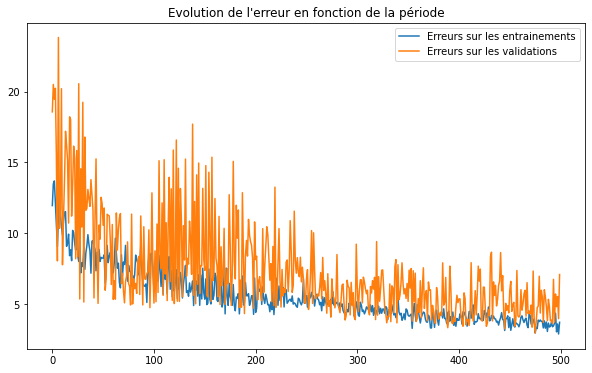

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

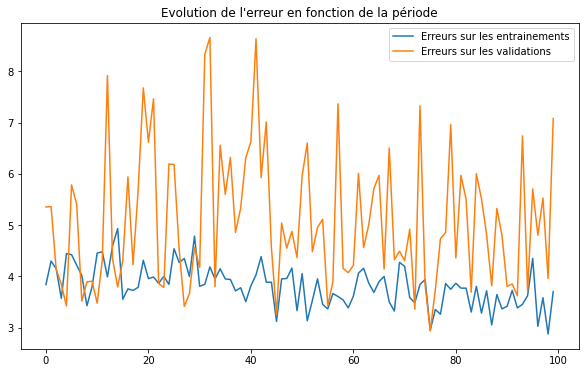

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [ ]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [ ]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupes (Nbr_Sequences, taille_fenetre) consécutifs de la série
# dans l'intervalle de validation
for t in temps[temps_separation:]:
    X = np.reshape(serie[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

ValueError: ignored

In [ ]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle de régression linéaire')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle de régression linéaire (zoom sur l'intervalle de validation)")
plt.show()

In [ ]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()

print(mae)
print(mse)